In [37]:
import pandas as pd 
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot
import torch.utils.data as data_utils

path = "/datasets/home/73/673/h6gupta/Challenge/challenge_dataset.csv"
data = pd.read_csv(path, header = None)
data = data.convert_objects(convert_numeric=True)

df1 = data.iloc[1:,2:16].values.reshape(205,89,14)

df1 = np.moveaxis(df1, [1,2], [2,1])

labels =[]
for i in range(1,206):
    labels.append(data.iloc[89*i,16])

labels = np.asarray(labels).astype('int64')
print(labels.shape)
print(df1.shape)

(205,)
(205, 14, 89)


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [38]:
X_train = (df1 - np.mean(df1, axis=0)[None,:,:]) / np.std(df1, axis=0)[None,:,:]

In [39]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels, stratify = labels, test_size = 0.215)

def one_hot(labels, n_class = 3):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"
    return y

y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)

img = torch.from_numpy(X_tr).float()
lbl = torch.from_numpy(y_tr).float()


batch_size = 40

train = data_utils.TensorDataset(img,lbl)
data_loader = data_utils.DataLoader(train, batch_size = batch_size, shuffle = True)
print(img.size())
print(lbl.size())
print(type(img))
print(type(lbl))


torch.Size([160, 14, 89])
torch.Size([160, 3])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [40]:
#Hyperparameters

batch_size = 40       # Batch size
seq_len = 89          # Number of steps
learning_rate = 0.0001
epochs = 50
n_classes = 3
n_channels = 14

def cross_entropy(input, target):
    logsoftmax = nn.LogSoftmax(dim = 1)
    return torch.mean(torch.mean(-target * logsoftmax(input), dim=1))


In [41]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_channels, 2*n_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d( 2*n_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2))  # 44
        self.layer2 = nn.Sequential(
            nn.Conv1d(2*n_channels,  4*n_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d( 4*n_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)) # 22
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(4*n_channels,  8*n_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d( 8*n_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)) ## 11
            
        self.layer4 = nn.Sequential(
            nn.Conv1d(8*n_channels,  16*n_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16*n_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2)) # 5
        
        self.layer5 = nn.Sequential(nn.Linear(5*16*n_channels, num_classes),nn.Softmax())
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.layer5(out)
        return out

    
def Network_Initialization(model):
    if(type(model) == nn.Linear):
        torch.nn.init.xavier_uniform_(model.weight)
        model.bias.data.fill_(0.01)
        
model = ConvNet(n_classes)
model.apply(Network_Initialization)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
yinit = model(img)

In [42]:
print("Training Loss is", cross_entropy(yinit, lbl).item())
def miss_classifications(yinit, lbl):
    _, predicted = torch.max(yinit.data, 1)
    miss_classifications = ((predicted != torch.max(lbl.data, 1)[1]).sum().item())
    return miss_classifications
print("Training Miss Classifcations",miss_classifications(yinit, lbl))

img_v1 = torch.from_numpy(X_vld).float()
lbl_v1 = torch.from_numpy(y_vld).float()
yinit_v1 = model(img_v1)

print("Testing Loss is", cross_entropy(yinit_v1, lbl_v1).item())
print("Total Testing Miss Classified Samples",((torch.max(yinit_v1.data, 1)[1] != torch.max(lbl_v1.data, 1)[1]).sum().item()))

('Training Loss is', 0.370667964220047)
('Training Miss Classifcations', 109)
('Testing Loss is', 0.3735184967517853)
('Total Testing Miss Classified Samples', 31)


In [43]:
Losses_Train =[]
for epoch in range(45):
    mc = 0
    for i, (images, labels) in enumerate(data_loader):
        outputs = model(images)
        loss = cross_entropy(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mc += miss_classifications(outputs, labels)
        print ('Epoch: {}, Loss: {}'.format(epoch+1, loss.item()))
    print ('Training Miss Classifications: {}'.format((mc)))
    Losses_Train.append(loss.item())

Epoch: 1, Loss: 0.377625823021
Epoch: 1, Loss: 0.369492292404
Epoch: 1, Loss: 0.349996685982
Epoch: 1, Loss: 0.373029887676
Training Miss Classifications: 101
Epoch: 2, Loss: 0.365305513144
Epoch: 2, Loss: 0.362172544003
Epoch: 2, Loss: 0.331963986158
Epoch: 2, Loss: 0.355119884014
Training Miss Classifications: 78
Epoch: 3, Loss: 0.340465188026
Epoch: 3, Loss: 0.338665097952
Epoch: 3, Loss: 0.344424307346
Epoch: 3, Loss: 0.340187251568
Training Miss Classifications: 68
Epoch: 4, Loss: 0.324634194374
Epoch: 4, Loss: 0.350172817707
Epoch: 4, Loss: 0.334838658571
Epoch: 4, Loss: 0.325890660286
Training Miss Classifications: 65
Epoch: 5, Loss: 0.328064918518
Epoch: 5, Loss: 0.350732505322
Epoch: 5, Loss: 0.323377221823
Epoch: 5, Loss: 0.313934385777
Training Miss Classifications: 64
Epoch: 6, Loss: 0.315798789263
Epoch: 6, Loss: 0.323817849159
Epoch: 6, Loss: 0.328250616789
Epoch: 6, Loss: 0.314272671938
Training Miss Classifications: 62
Epoch: 7, Loss: 0.305384457111
Epoch: 7, Loss: 0.32

In [44]:
img_v1 = torch.from_numpy(X_vld).float()
lbl_v1 = torch.from_numpy(y_vld).float()
yinit_v1 = model(img_v1)
print("Testing Loss is", cross_entropy(yinit_v1, lbl_v1).item())
print(miss_classifications(yinit_v1, lbl_v1))

('Testing Loss is', 0.3270931541919708)
18


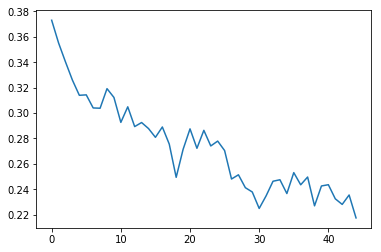

In [45]:
t = np.arange(45)
pyplot.plot(t,Losses_Train)
pyplot.show()

('Total Miss Classified Samples', 18)
[[12  1  3]
 [ 3 12  1]
 [ 7  3  3]]


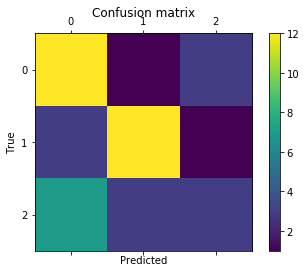

In [46]:
from sklearn.metrics import confusion_matrix

preds= torch.max(yinit_v1.data, 1)[1].numpy()
true = torch.max(lbl_v1.data, 1)[1].numpy()
Conf_Labels = [0,1,2]
conf_matrix = confusion_matrix(true, preds, Conf_Labels)
print("Total Miss Classified Samples",((torch.max(yinit_v1.data, 1)[1] != torch.max(lbl_v1.data, 1)[1]).sum().item()))
print(conf_matrix)
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
pyplot.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + Conf_Labels)
ax.set_yticklabels([''] + Conf_Labels)
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.show()